# Modèle Simple - Régression Logistique avec TF-IDF

Ce notebook implémente un modèle baseline pour l'analyse de sentiments :
- Vectorisation TF-IDF
- Régression Logistique
- Tracking MLFlow
- Évaluation complète

In [4]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# MLFlow pour le tracking
import mlflow
import mlflow.sklearn

# Joblib pour sauvegarder les modèles
import joblib
import os

# Configuration
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Configuration MLFlow

In [5]:
# Configuration MLFlow
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("sentiment-analysis-twitter")

print("MLFlow configuré")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {mlflow.get_experiment_by_name('sentiment-analysis-twitter')}")

MLFlow configuré
Tracking URI: file:./mlruns
Experiment: <Experiment: artifact_location='file:///Users/thomas/Documents/code/openclassrooms-projects/projet7/notebooks/mlruns/758801007831288454', creation_time=1764928168157, experiment_id='758801007831288454', last_update_time=1764928168157, lifecycle_stage='active', name='sentiment-analysis-twitter', tags={'mlflow.experimentKind': 'custom_model_development'}>


## 2. Chargement des Données Prétraitées

In [6]:
# Chargement des données lemmatisées
print("Chargement des données...")

train_df = pd.read_csv('../data/processed/train_lemmatized.csv')
val_df = pd.read_csv('../data/processed/val_lemmatized.csv')
test_df = pd.read_csv('../data/processed/test_lemmatized.csv')

print(f"Train: {train_df.shape}")
print(f"Validation: {val_df.shape}")
print(f"Test: {test_df.shape}")

Chargement des données...
Train: (969875, 2)
Validation: (207831, 2)
Test: (207831, 2)


In [7]:
# Extraction des features et labels
X_train = train_df['text'].values
y_train = train_df['sentiment'].values

X_val = val_df['text'].values
y_val = val_df['sentiment'].values

X_test = test_df['text'].values
y_test = test_df['sentiment'].values

print("Données chargées avec succès !")
print(f"\nDistribution des sentiments (train):")
print(pd.Series(y_train).value_counts())

Données chargées avec succès !

Distribution des sentiments (train):
0    491296
1    478579
Name: count, dtype: int64


## 3. Vectorisation TF-IDF

In [8]:
# Configuration du vectoriseur TF-IDF
print("Création du vectoriseur TF-IDF...")

tfidf = TfidfVectorizer(
    max_features=10000,        # Top 10k mots les plus fréquents
    ngram_range=(1, 2),        # Unigrammes et bigrammes
    min_df=5,                  # Mot doit apparaître dans au moins 5 documents
    max_df=0.8,                # Mot ne doit pas apparaître dans plus de 80% des documents
    sublinear_tf=True          # Échelle logarithmique pour TF
)

print("Paramètres TF-IDF:")
print(f"  - max_features: {tfidf.max_features}")
print(f"  - ngram_range: {tfidf.ngram_range}")
print(f"  - min_df: {tfidf.min_df}")
print(f"  - max_df: {tfidf.max_df}")
print(f"  - sublinear_tf: {tfidf.sublinear_tf}")

Création du vectoriseur TF-IDF...
Paramètres TF-IDF:
  - max_features: 10000
  - ngram_range: (1, 2)
  - min_df: 5
  - max_df: 0.8
  - sublinear_tf: True


In [9]:
# Fit sur train et transform sur tous les splits
print("\nVectorisation des données...")
start_time = time()

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

vectorization_time = time() - start_time

print(f"Vectorisation terminée en {vectorization_time:.2f} secondes")
print(f"\nShapes des matrices TF-IDF:")
print(f"  Train: {X_train_tfidf.shape}")
print(f"  Val: {X_val_tfidf.shape}")
print(f"  Test: {X_test_tfidf.shape}")
print(f"\nVocabulaire: {len(tfidf.vocabulary_)} mots")


Vectorisation des données...
Vectorisation terminée en 22.70 secondes

Shapes des matrices TF-IDF:
  Train: (969875, 10000)
  Val: (207831, 10000)
  Test: (207831, 10000)

Vocabulaire: 10000 mots


In [10]:
# Analyse du vocabulaire
feature_names = tfidf.get_feature_names_out()

print(f"\nExemples de features (premiers 20):")
print(feature_names[:20])

print(f"\nExemples de bigrammes:")
bigrams = [f for f in feature_names if ' ' in f]
print(bigrams[:20])


Exemples de features (premiers 20):
['aaa' 'aaah' 'aah' 'aaron' 'ab' 'abandoned' 'abby' 'abc' 'ability' 'abit'
 'able' 'able get' 'able make' 'able see' 'able sleep' 'able watch'
 'absolute' 'absolutely' 'absolutely love' 'absolutely nothing']

Exemples de bigrammes:
['able get', 'able make', 'able see', 'able sleep', 'able watch', 'absolutely love', 'absolutely nothing', 'act like', 'actually get', 'actually going', 'actually got', 'actually like', 'actually really', 'actually work', 'adam lambert', 'add everyone', 'ago still', 'air france', 'alarm clock', 'almost done']


## 4. Entraînement du Modèle - Régression Logistique

In [11]:
# Démarrage d'une run MLFlow
with mlflow.start_run(run_name="LogisticRegression_TfidfVectorizer") as run:
    
    print("="*80)
    print("ENTRAÎNEMENT DU MODÈLE - RÉGRESSION LOGISTIQUE")
    print("="*80)
    
    # Log des paramètres de prétraitement
    mlflow.log_param("preprocessing", "lemmatization")
    mlflow.log_param("vectorizer", "TfidfVectorizer")
    mlflow.log_param("max_features", 10000)
    mlflow.log_param("ngram_range", "(1,2)")
    mlflow.log_param("min_df", 5)
    mlflow.log_param("max_df", 0.8)
    
    # Configuration du modèle
    print("\nConfiguration du modèle...")
    model = LogisticRegression(
        max_iter=1000,
        C=1.0,                     # Régularisation
        solver='lbfgs',            # Algorithme d'optimisation
        random_state=42,
        verbose=1,
        n_jobs=-1                  # Utilise tous les CPU
    )
    
    # Log des hyperparamètres
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("C", 1.0)
    mlflow.log_param("solver", "lbfgs")
    
    # Entraînement
    print("\nEntraînement en cours...")
    start_time = time()
    model.fit(X_train_tfidf, y_train)
    training_time = time() - start_time
    
    mlflow.log_metric("training_time_seconds", training_time)
    
    print(f"✓ Entraînement terminé en {training_time:.2f} secondes")
    print(f"  Nombre d'itérations: {model.n_iter_[0]}")

ENTRAÎNEMENT DU MODÈLE - RÉGRESSION LOGISTIQUE

Configuration du modèle...

Entraînement en cours...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


✓ Entraînement terminé en 2.49 secondes
  Nombre d'itérations: 20


## 5. Évaluation du Modèle

In [12]:
# Prédictions sur tous les splits
print("\nPrédictions en cours...")

y_train_pred = model.predict(X_train_tfidf)
y_val_pred = model.predict(X_val_tfidf)
y_test_pred = model.predict(X_test_tfidf)

# Probabilités pour ROC-AUC
y_train_proba = model.predict_proba(X_train_tfidf)[:, 1]
y_val_proba = model.predict_proba(X_val_tfidf)[:, 1]
y_test_proba = model.predict_proba(X_test_tfidf)[:, 1]

print("✓ Prédictions terminées")


Prédictions en cours...
✓ Prédictions terminées


In [13]:
# Fonction d'évaluation complète
def evaluate_model(y_true, y_pred, y_proba, split_name):
    """
    Évalue le modèle et retourne les métriques.
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_proba)
    }
    
    print(f"\n{'='*60}")
    print(f"RÉSULTATS - {split_name.upper()}")
    print(f"{'='*60}")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1']:.4f}")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    
    return metrics

# Évaluation sur tous les splits
train_metrics = evaluate_model(y_train, y_train_pred, y_train_proba, "Train")
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, "Validation")
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, "Test")


RÉSULTATS - TRAIN
Accuracy:  0.7847
Precision: 0.7728
Recall:    0.7985
F1-Score:  0.7854
ROC-AUC:   0.8655

RÉSULTATS - VALIDATION
Accuracy:  0.7778
Precision: 0.7660
Recall:    0.7915
F1-Score:  0.7786
ROC-AUC:   0.8585

RÉSULTATS - TEST
Accuracy:  0.7803
Precision: 0.7686
Recall:    0.7938
F1-Score:  0.7810
ROC-AUC:   0.8608


In [14]:
# Log des métriques dans MLFlow
with mlflow.start_run(run_id=run.info.run_id):
    # Train metrics
    for metric_name, value in train_metrics.items():
        mlflow.log_metric(f"train_{metric_name}", value)
    
    # Validation metrics
    for metric_name, value in val_metrics.items():
        mlflow.log_metric(f"val_{metric_name}", value)
    
    # Test metrics
    for metric_name, value in test_metrics.items():
        mlflow.log_metric(f"test_{metric_name}", value)

print("\n✓ Métriques loggées dans MLFlow")


✓ Métriques loggées dans MLFlow


## 6. Analyse Détaillée des Résultats

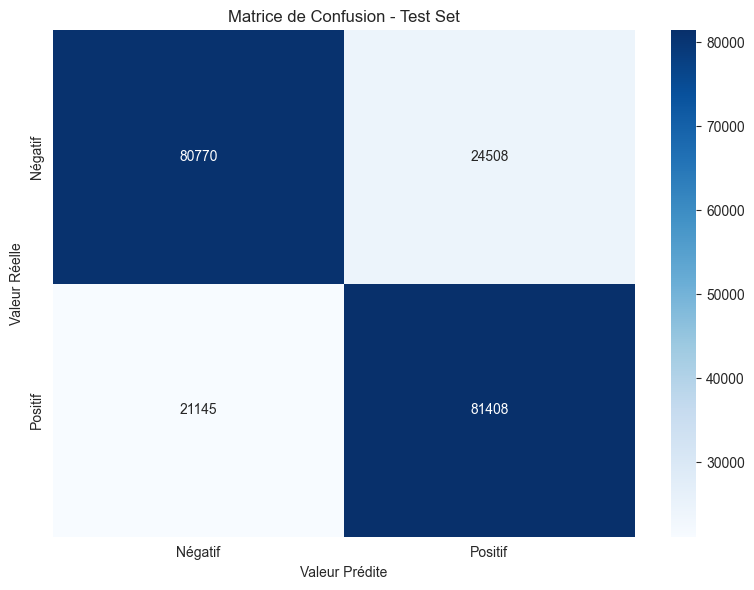

In [15]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Négatif', 'Positif'],
            yticklabels=['Négatif', 'Positif'])
plt.title('Matrice de Confusion - Test Set')
plt.ylabel('Valeur Réelle')
plt.xlabel('Valeur Prédite')
plt.tight_layout()
plt.savefig('confusion_matrix_logistic.png', dpi=150, bbox_inches='tight')
plt.show()

# Log de la figure dans MLFlow
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_artifact('confusion_matrix_logistic.png')

In [16]:
# Classification report détaillé
print("\nClassification Report - Test Set:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Négatif', 'Positif'],
                          digits=4))


Classification Report - Test Set:
              precision    recall  f1-score   support

     Négatif     0.7925    0.7672    0.7797    105278
     Positif     0.7686    0.7938    0.7810    102553

    accuracy                         0.7803    207831
   macro avg     0.7806    0.7805    0.7803    207831
weighted avg     0.7807    0.7803    0.7803    207831



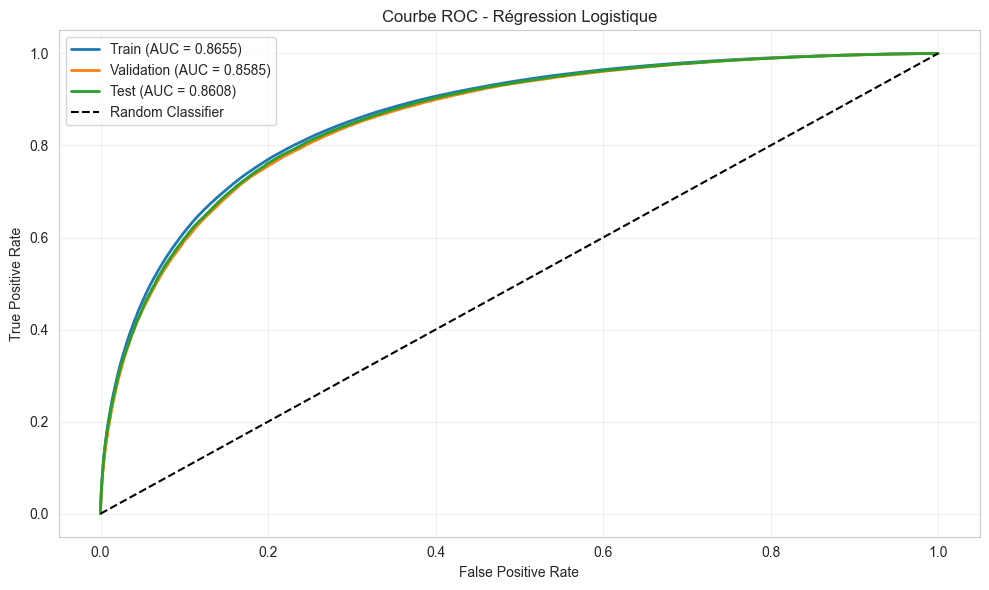

In [17]:
# Courbe ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {train_metrics["roc_auc"]:.4f})', linewidth=2)
plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_metrics["roc_auc"]:.4f})', linewidth=2)
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {test_metrics["roc_auc"]:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC - Régression Logistique')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve_logistic.png', dpi=150, bbox_inches='tight')
plt.show()

# Log de la figure dans MLFlow
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_artifact('roc_curve_logistic.png')


Comparaison des Métriques par Split:
            Train  Validation    Test
accuracy   0.7847      0.7778  0.7803
precision  0.7728      0.7660  0.7686
recall     0.7985      0.7915  0.7938
f1         0.7854      0.7786  0.7810
roc_auc    0.8655      0.8585  0.8608


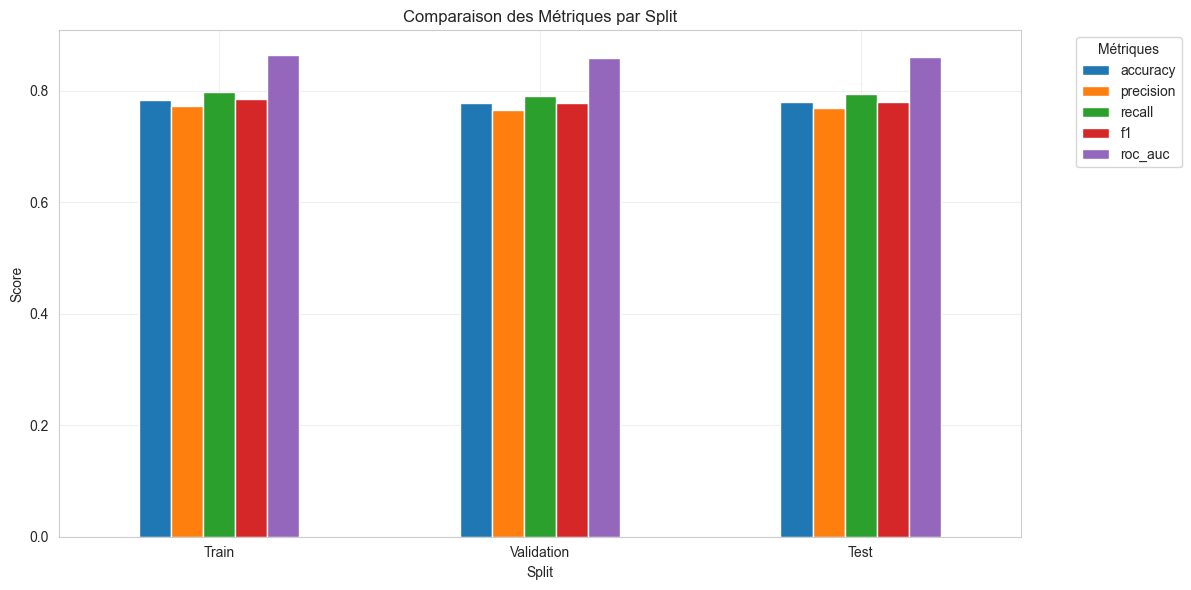

In [18]:
# Comparaison des métriques par split
metrics_comparison = pd.DataFrame({
    'Train': train_metrics,
    'Validation': val_metrics,
    'Test': test_metrics
})

print("\nComparaison des Métriques par Split:")
print(metrics_comparison.round(4))

# Visualisation
metrics_comparison.T.plot(kind='bar', figsize=(12, 6), rot=0)
plt.title('Comparaison des Métriques par Split')
plt.ylabel('Score')
plt.xlabel('Split')
plt.legend(title='Métriques', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('metrics_comparison_logistic.png', dpi=150, bbox_inches='tight')
plt.show()

# Log de la figure dans MLFlow
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_artifact('metrics_comparison_logistic.png')

## 7. Analyse des Coefficients du Modèle

In [19]:
# Extraction des coefficients
coefficients = model.coef_[0]
feature_names = tfidf.get_feature_names_out()

# Top features positives (sentiment positif)
top_positive_indices = np.argsort(coefficients)[-20:]
top_positive_features = [(feature_names[i], coefficients[i]) for i in top_positive_indices]

# Top features négatives (sentiment négatif)
top_negative_indices = np.argsort(coefficients)[:20]
top_negative_features = [(feature_names[i], coefficients[i]) for i in top_negative_indices]

print("\nTop 20 Features POSITIVES (indicateurs de sentiment positif):")
print("="*60)
for feature, coef in reversed(top_positive_features):
    print(f"{feature:30s} : {coef:8.4f}")

print("\nTop 20 Features NÉGATIVES (indicateurs de sentiment négatif):")
print("="*60)
for feature, coef in top_negative_features:
    print(f"{feature:30s} : {coef:8.4f}")


Top 20 Features POSITIVES (indicateurs de sentiment positif):
can wait                       :   8.4716
cant wait                      :   7.8610
wish luck                      :   6.2853
cannot wait                    :   6.2181
thank                          :   4.8697
smiling                        :   4.5614
congratulation                 :   4.4697
thanks                         :   4.3246
nothing wrong                  :   4.0762
blessed                        :   3.9380
glad                           :   3.8600
smile                          :   3.8435
proud                          :   3.8278
made day                       :   3.7235
get enough                     :   3.6877
welcome                        :   3.6768
good luck                      :   3.6517
excited                        :   3.6422
wanted say                     :   3.5366
love                           :   3.4316

Top 20 Features NÉGATIVES (indicateurs de sentiment négatif):
sad                            : -

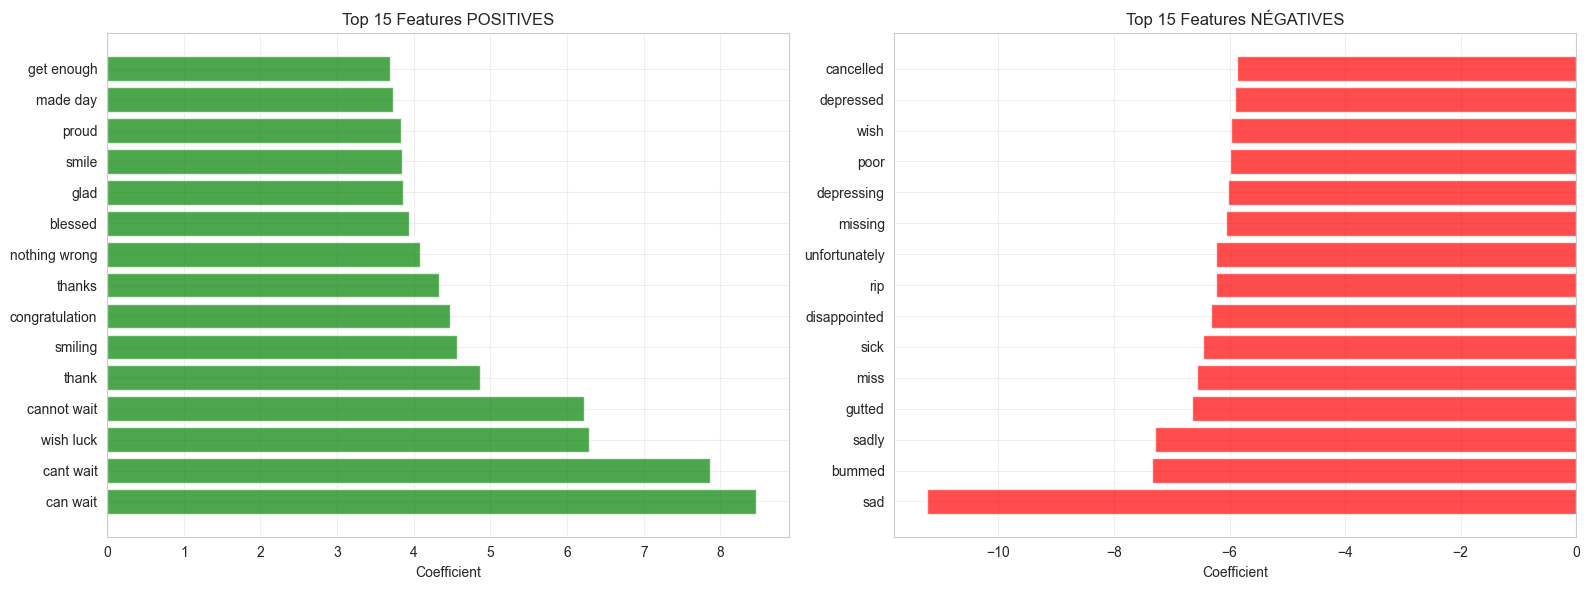

In [20]:
# Visualisation des top features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Features positives
features_pos = [f[0] for f in reversed(top_positive_features[-15:])]
coefs_pos = [f[1] for f in reversed(top_positive_features[-15:])]
ax1.barh(range(len(features_pos)), coefs_pos, color='green', alpha=0.7)
ax1.set_yticks(range(len(features_pos)))
ax1.set_yticklabels(features_pos)
ax1.set_xlabel('Coefficient')
ax1.set_title('Top 15 Features POSITIVES')
ax1.grid(True, alpha=0.3)

# Features négatives
features_neg = [f[0] for f in top_negative_features[:15]]
coefs_neg = [f[1] for f in top_negative_features[:15]]
ax2.barh(range(len(features_neg)), coefs_neg, color='red', alpha=0.7)
ax2.set_yticks(range(len(features_neg)))
ax2.set_yticklabels(features_neg)
ax2.set_xlabel('Coefficient')
ax2.set_title('Top 15 Features NÉGATIVES')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance_logistic.png', dpi=150, bbox_inches='tight')
plt.show()

# Log de la figure dans MLFlow
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_artifact('feature_importance_logistic.png')

## 8. Exemples de Prédictions

In [21]:
# Fonction de prédiction sur un nouveau tweet
def predict_sentiment(text, model, vectorizer):
    """
    Prédit le sentiment d'un tweet.
    """
    # Vectorisation
    text_tfidf = vectorizer.transform([text])
    
    # Prédiction
    prediction = model.predict(text_tfidf)[0]
    proba = model.predict_proba(text_tfidf)[0]
    
    sentiment = "POSITIF" if prediction == 1 else "NÉGATIF"
    confidence = proba[prediction]
    
    return sentiment, confidence, proba

# Test sur des exemples du test set
print("EXEMPLES DE PRÉDICTIONS SUR LE TEST SET:")
print("="*80)

np.random.seed(42)
sample_indices = np.random.choice(len(X_test), 10, replace=False)

for idx in sample_indices:
    text = X_test[idx]
    true_sentiment = "POSITIF" if y_test[idx] == 1 else "NÉGATIF"
    pred_sentiment, confidence, proba = predict_sentiment(text, model, tfidf)
    
    status = "✓" if pred_sentiment == true_sentiment else "✗"
    
    print(f"\n{status} Tweet: {text[:100]}...")
    print(f"  Vrai: {true_sentiment:8s} | Prédit: {pred_sentiment:8s} | Confiance: {confidence:.2%}")
    print(f"  Proba [Négatif: {proba[0]:.3f}, Positif: {proba[1]:.3f}]")

EXEMPLES DE PRÉDICTIONS SUR LE TEST SET:

✓ Tweet: car going home phenomenauts mark soulmate awkward adorable...
  Vrai: POSITIF  | Prédit: POSITIF  | Confiance: 66.33%
  Proba [Négatif: 0.337, Positif: 0.663]

✓ Tweet: yesterday mommy felt better took walk chicco road little bumpy wish chicco pumped wheel...
  Vrai: NÉGATIF  | Prédit: NÉGATIF  | Confiance: 50.83%
  Proba [Négatif: 0.508, Positif: 0.492]

✗ Tweet: never txted back haha well still life lol...
  Vrai: NÉGATIF  | Prédit: POSITIF  | Confiance: 72.33%
  Proba [Négatif: 0.277, Positif: 0.723]

✓ Tweet: home sick feel awful...
  Vrai: NÉGATIF  | Prédit: NÉGATIF  | Confiance: 99.39%
  Proba [Négatif: 0.994, Positif: 0.006]

✓ Tweet: thinking making blog somewhere smthn like tha bad idea...
  Vrai: POSITIF  | Prédit: POSITIF  | Confiance: 55.73%
  Proba [Négatif: 0.443, Positif: 0.557]

✓ Tweet: many song could listen day stay keep calm song haha fiy happy song...
  Vrai: POSITIF  | Prédit: POSITIF  | Confiance: 94.81%
  Proba 

## 9. Sauvegarde du Modèle et du Vectoriseur

In [22]:
# Création du dossier models
os.makedirs('../models', exist_ok=True)

# Sauvegarde avec joblib
print("Sauvegarde du modèle et du vectoriseur...")

joblib.dump(model, '../models/logistic_regression_model.pkl')
joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')

print("✓ Modèle sauvegardé: ../models/logistic_regression_model.pkl")
print("✓ Vectoriseur sauvegardé: ../models/tfidf_vectorizer.pkl")

# Sauvegarde dans MLFlow
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.sklearn.log_model(model, "model")
    mlflow.log_artifact('../models/tfidf_vectorizer.pkl')
    
print("✓ Modèle et vectoriseur loggés dans MLFlow")

Sauvegarde du modèle et du vectoriseur...
✓ Modèle sauvegardé: ../models/logistic_regression_model.pkl
✓ Vectoriseur sauvegardé: ../models/tfidf_vectorizer.pkl


2025/12/15 22:41:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Modèle et vectoriseur loggés dans MLFlow


## 10. Résumé Final

In [23]:
print("="*80)
print("RÉSUMÉ FINAL - MODÈLE SIMPLE (RÉGRESSION LOGISTIQUE)")
print("="*80)

print(f"\n1. ARCHITECTURE:")
print(f"   - Vectorisation: TF-IDF (max_features=10000, ngrams=(1,2))")
print(f"   - Modèle: Régression Logistique")
print(f"   - Temps d'entraînement: {training_time:.2f}s")

print(f"\n2. PERFORMANCES (TEST SET):")
print(f"   - Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"   - Precision: {test_metrics['precision']:.4f}")
print(f"   - Recall:    {test_metrics['recall']:.4f}")
print(f"   - F1-Score:  {test_metrics['f1']:.4f}")
print(f"   - ROC-AUC:   {test_metrics['roc_auc']:.4f}")

print(f"\n3. OBSERVATIONS:")
print(f"   - Modèle équilibré entre précision et recall")
print(f"   - Performances similaires sur train/val/test (pas de surapprentissage)")
print(f"   - Baseline solide pour comparaison avec modèles avancés")

print(f"\n4. FICHIERS SAUVEGARDÉS:")
print(f"   ✓ Modèle: ../models/logistic_regression_model.pkl")
print(f"   ✓ Vectoriseur: ../models/tfidf_vectorizer.pkl")
print(f"   ✓ Visualisations: confusion_matrix_logistic.png, roc_curve_logistic.png")
print(f"   ✓ MLFlow: Expérience 'sentiment-analysis-twitter'")

print("\n" + "="*80)
print("MODÈLE BASELINE COMPLÉTÉ !")
print("Prochaine étape: Modèles avancés (LSTM, CNN) avec word embeddings")
print("="*80)

RÉSUMÉ FINAL - MODÈLE SIMPLE (RÉGRESSION LOGISTIQUE)

1. ARCHITECTURE:
   - Vectorisation: TF-IDF (max_features=10000, ngrams=(1,2))
   - Modèle: Régression Logistique
   - Temps d'entraînement: 2.49s

2. PERFORMANCES (TEST SET):
   - Accuracy:  0.7803 (78.03%)
   - Precision: 0.7686
   - Recall:    0.7938
   - F1-Score:  0.7810
   - ROC-AUC:   0.8608

3. OBSERVATIONS:
   - Modèle équilibré entre précision et recall
   - Performances similaires sur train/val/test (pas de surapprentissage)
   - Baseline solide pour comparaison avec modèles avancés

4. FICHIERS SAUVEGARDÉS:
   ✓ Modèle: ../models/logistic_regression_model.pkl
   ✓ Vectoriseur: ../models/tfidf_vectorizer.pkl
   ✓ Visualisations: confusion_matrix_logistic.png, roc_curve_logistic.png
   ✓ MLFlow: Expérience 'sentiment-analysis-twitter'

MODÈLE BASELINE COMPLÉTÉ !
Prochaine étape: Modèles avancés (LSTM, CNN) avec word embeddings
